In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from yellowbrick.classifier import ClassificationReport

%matplotlib inline
pd.set_option('display.max_columns', 55)

In [2]:
#read in csv
df = pd.read_csv("eda.csv")

### See notebook 2 features selection for explanation about why we choosed those features and split train test method

In [5]:
features = df[[
    'x', 
    'y',
    'dayofweek', 
    'sin_day', 
    'cos_day',
    'sin_year', 
    'cos_year', 
    'TEMP', 
    'cos_wind', 
    'sin_wind', 
    'Wind-Rate', 
    'DEW', 
    'SKY', 
    'VIS', 
    'ATM'
]].astype(np.float64)

features.loc[:,'dayofweek'] = features['dayofweek'].astype('category')

labels = df[[
    'pm25',
    'AQI_VALUE', #pm25 transformed using EPA methodology See DATA Wrangling notebook
    'AQI_class'  #pm25 transformed into EPA categorical class  See DATA Wrangling notebook
]]
labels.loc[:,"polluted"] = (labels.loc[:,"AQI_class"] != "Good")

y = labels['polluted'].values
y = LabelEncoder().fit_transform(y)
X=features

gs = df[['station_id']]

def tts_gs(X, y, gs, test_size):
    stations = gs["station_id"].unique()
    nb_stations = len(stations) * test_size
    my_randoms = random.sample(list(stations), int(nb_stations))
    filters = gs["station_id"].isin(my_randoms)
    print('Substations selected for testing are : ')
    print(my_randoms)
    return X[~filters], X[filters], y[~filters], y[filters]


numericColumns = ['x','y',
    'dayofweek', 'sin_day', 'cos_day', 'sin_year', 'cos_year', 
    'TEMP', 'cos_wind', 'sin_wind', 'Wind-Rate', 'DEW', 'SKY', 'VIS',  'ATM'
    ]
categoricalColumns = ['dayofweek']

numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


In [6]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)

    model = Pipeline([
     ('preprocessor', ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numericColumns),
        ('cat', categorical_transformer, categoricalColumns)])),
     ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [7]:
# Try them all! Looking for Pokemons

models = [
    SVC(gamma='auto'),
    # NuSVC(gamma='auto'), 
    LinearSVC(), 
    #SGDClassifier(max_iter=100, tol=1e-3), 
    KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), #LogisticRegressionCV(cv=3), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100),
    DecisionTreeClassifier()
]


for model in models:
    score_model(X, y, model)

SVC: 0.275444345149439
LinearSVC: 0.0007155635062611806
KNeighborsClassifier: 0.6596370143149284
LogisticRegression: 0.01696885169688517
BaggingClassifier: 0.9802424242424244
ExtraTreesClassifier: 1.0
RandomForestClassifier: 1.0
DecisionTreeClassifier: 1.0


# First conclusions

A pretty good F1 may be possible for some models :

* Bagging
* ExtraTrees 
* DecisionTrees
* RandomForest

Also, results seems too good **overfitted** most probably.

2 Points were then taken in account
* first evaluate and use a train test split strategy using diferent locations (ground station id). In order to be sure to evaluate completely new stations after training data on another ones.
* Making several folding train test split to get a mean and variance of our results

## Also keeping our goal into mind

* We want to predict bad air quality as much as correct as possible : We will focus on **recall of predicting a false negative / of predicting Good Air quality when air quality was bad in reality**





In [8]:
models = [
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100),
    DecisionTreeClassifier()
]

Test substations selected: 
['Arlington', 'DC_EPA_4', 'VA_EPA']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


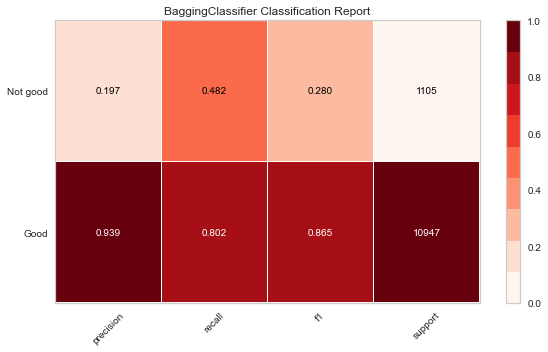

 > F1 Not good 0.28023133543638273 and recall not good 0.4823529411764706.

Test substations selected: 
['MA_EPA_2', 'DC_EPA_3', 'MA_EPA_1']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


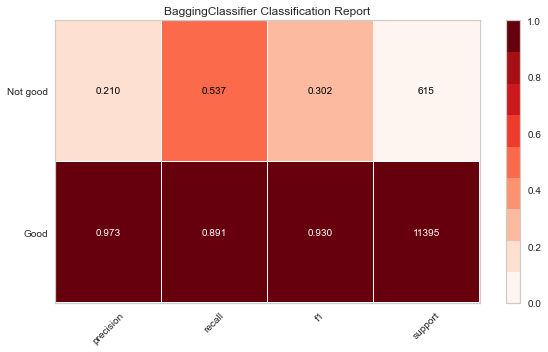

 > F1 Not good 0.30205949656750575 and recall not good 0.5365853658536586.

Test substations selected: 
['13th & E ST SE', '14th & S ST NW', 'V Street']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


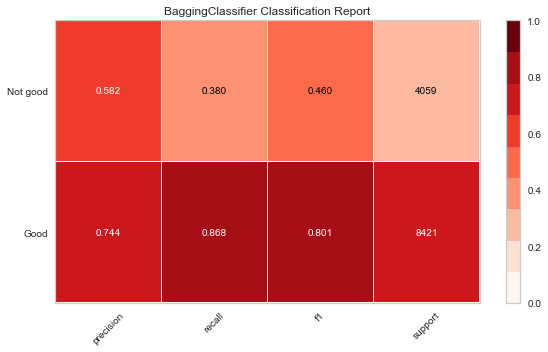

 > F1 Not good 0.4598420503650723 and recall not good 0.3801428923380143.

Test substations selected: 
['Cheverly', 'DC_EPA_2', 'DC_EPA_1']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


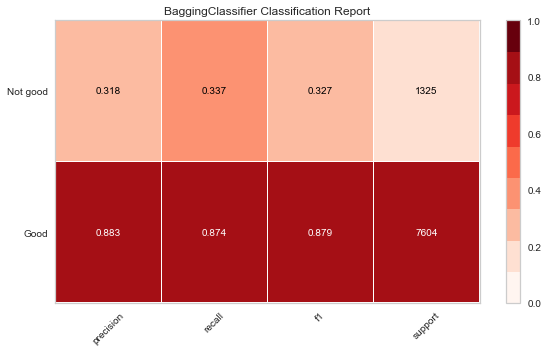

 > F1 Not good 0.32721936903888477 and recall not good 0.3366037735849057.

Test substations selected: 
['McMillan 1', 'Courthouse']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


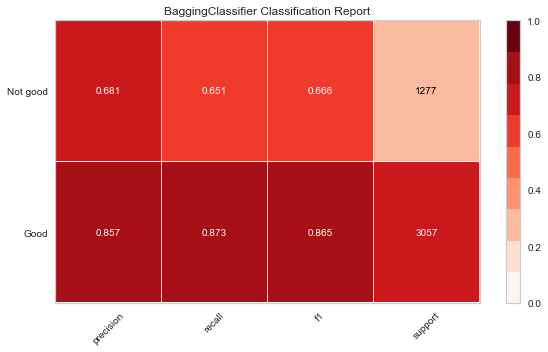

 > F1 Not good 0.6655987184621546 and recall not good 0.6507439310884886.

 >> Mean F1 score 0.40699019397399994


['BaggingClassifier', 0.28023133543638273, 0.30205949656750575, 0.4598420503650723, 0.32721936903888477, 0.6655987184621546, 0.020622666329744938, 0.40699019397399994, 0.012571602947225303, 0.47728578080830764]
Test substations selected: 
['Arlington', 'DC_EPA_4', 'VA_EPA']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


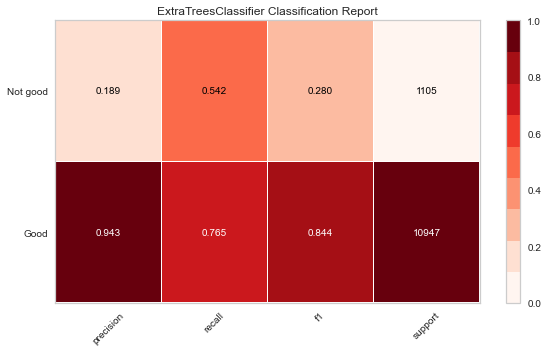

 > F1 Not good 0.2798411586078019 and recall not good 0.5420814479638009.

Test substations selected: 
['MA_EPA_2', 'DC_EPA_3', 'MA_EPA_1']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


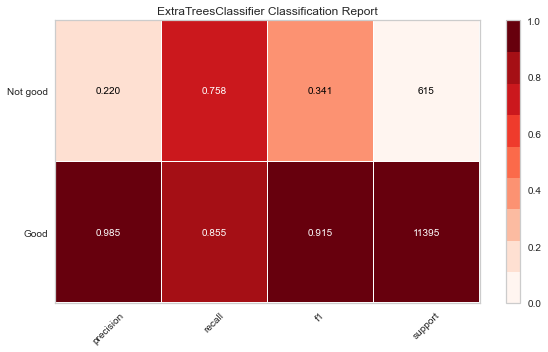

 > F1 Not good 0.34089246525237743 and recall not good 0.7577235772357723.

Test substations selected: 
['13th & E ST SE', '14th & S ST NW', 'V Street']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


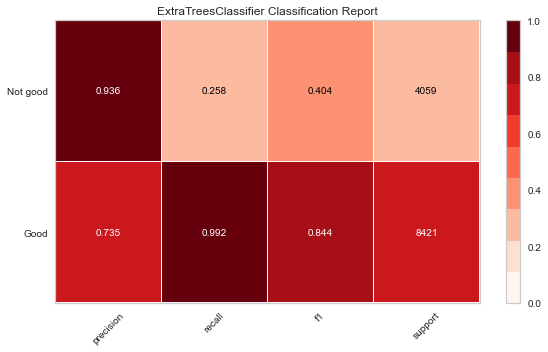

 > F1 Not good 0.40448135986092326 and recall not good 0.2579453067257945.

Test substations selected: 
['Cheverly', 'DC_EPA_2', 'DC_EPA_1']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


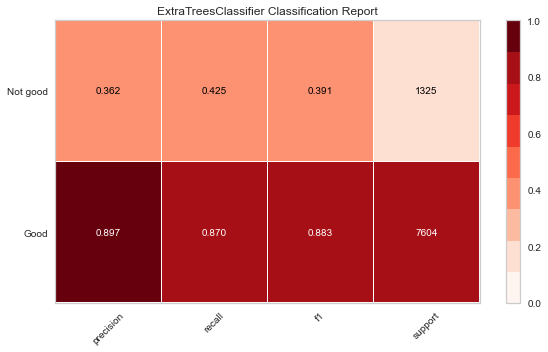

 > F1 Not good 0.3909722222222223 and recall not good 0.4249056603773585.

Test substations selected: 
['McMillan 1', 'Courthouse']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


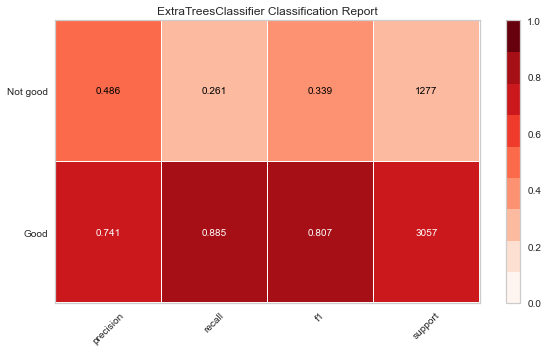

 > F1 Not good 0.33944954128440363 and recall not good 0.26076742364917777.

 >> Mean F1 score 0.3511273494455457


['ExtraTreesClassifier', 0.2798411586078019, 0.34089246525237743, 0.40448135986092326, 0.3909722222222223, 0.33944954128440363, 0.001951421875208998, 0.3511273494455457, 0.03529756835929151, 0.4486846831903808]
Test substations selected: 
['Arlington', 'DC_EPA_4', 'VA_EPA']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


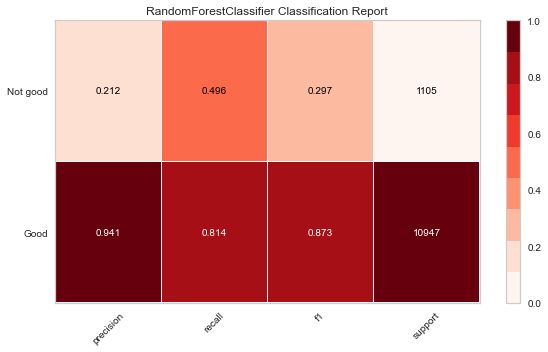

 > F1 Not good 0.29709948495527244 and recall not good 0.49592760180995477.

Test substations selected: 
['MA_EPA_2', 'DC_EPA_3', 'MA_EPA_1']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


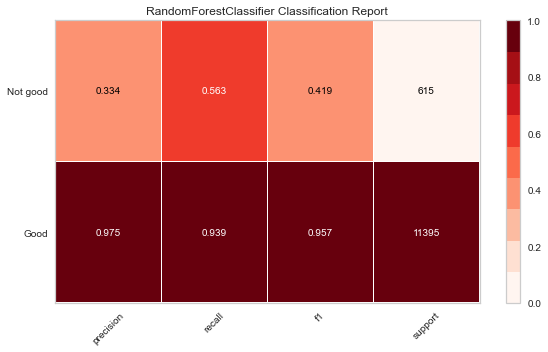

 > F1 Not good 0.4188861985472155 and recall not good 0.5626016260162602.

Test substations selected: 
['13th & E ST SE', '14th & S ST NW', 'V Street']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


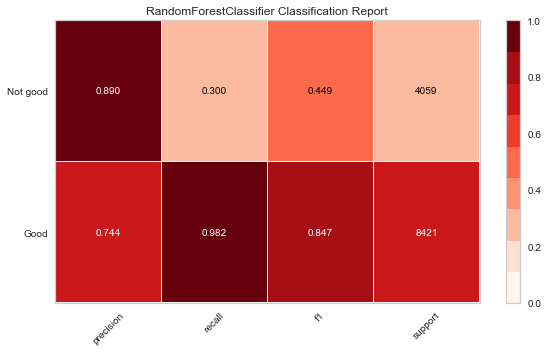

 > F1 Not good 0.44858090674530043 and recall not good 0.29982754372998277.

Test substations selected: 
['Cheverly', 'DC_EPA_2', 'DC_EPA_1']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


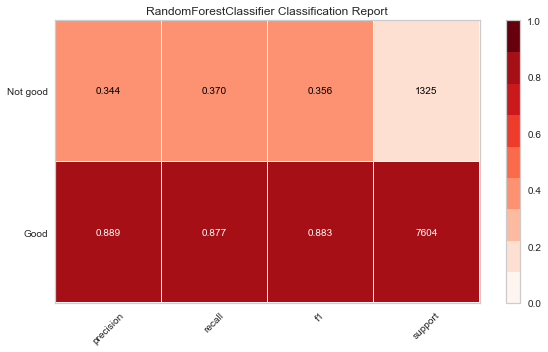

 > F1 Not good 0.35649327028010186 and recall not good 0.36981132075471695.

Test substations selected: 
['McMillan 1', 'Courthouse']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


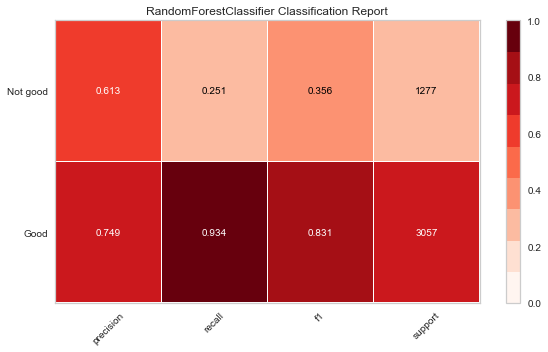

 > F1 Not good 0.3564686285397002 and recall not good 0.2513703993735317.

 >> Mean F1 score 0.37550569781351806


['RandomForestClassifier', 0.29709948495527244, 0.4188861985472155, 0.44858090674530043, 0.35649327028010186, 0.3564686285397002, 0.0028186541252704063, 0.37550569781351806, 0.013718858887951607, 0.39590769833688927]
Test substations selected: 
['Arlington', 'DC_EPA_4', 'VA_EPA']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


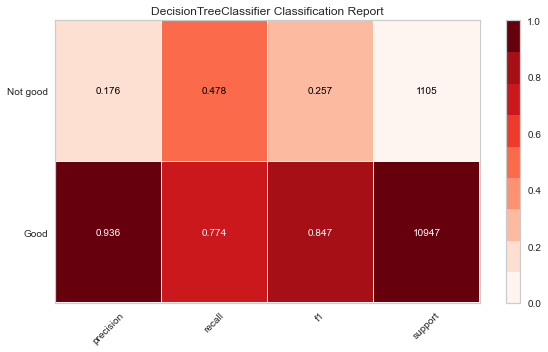

 > F1 Not good 0.2568718073461445 and recall not good 0.47782805429864256.

Test substations selected: 
['MA_EPA_2', 'DC_EPA_3', 'MA_EPA_1']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


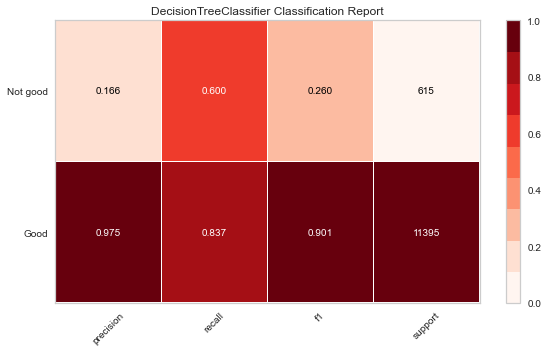

 > F1 Not good 0.25995068686157097 and recall not good 0.6.

Test substations selected: 
['13th & E ST SE', '14th & S ST NW', 'V Street']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


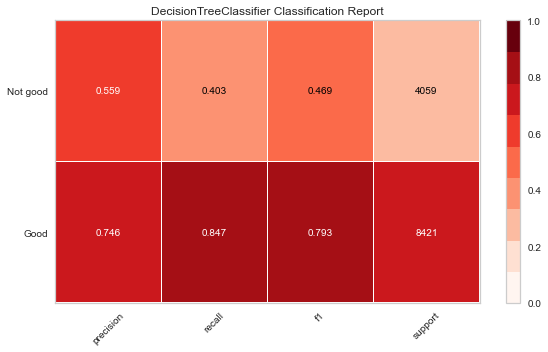

 > F1 Not good 0.46858451409760987 and recall not good 0.40330130574033013.

Test substations selected: 
['Cheverly', 'DC_EPA_2', 'DC_EPA_1']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


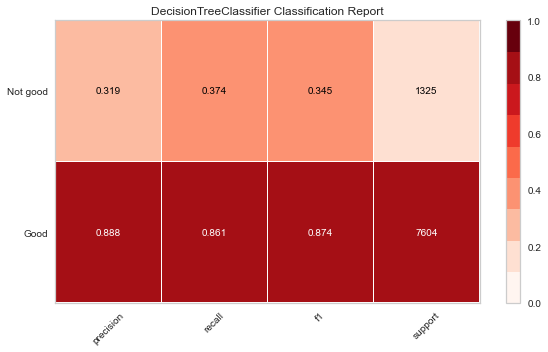

 > F1 Not good 0.3445640847516499 and recall not good 0.37433962264150944.

Test substations selected: 
['McMillan 1', 'Courthouse']


c:\users\colla\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


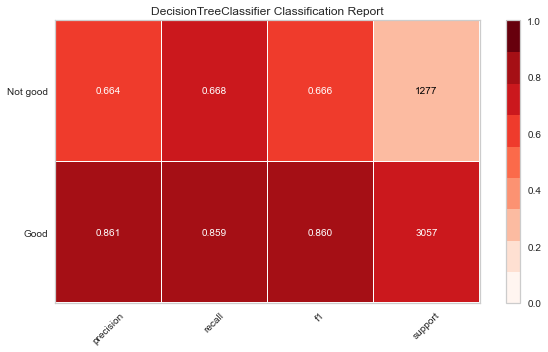

 > F1 Not good 0.6658860265417642 and recall not good 0.6679718089271731.

 >> Mean F1 score 0.39917142391974797


['DecisionTreeClassifier', 0.2568718073461445, 0.25995068686157097, 0.46858451409760987, 0.3445640847516499, 0.6658860265417642, 0.023713682466979268, 0.39917142391974797, 0.012747479507523068, 0.504688158321531]


In [12]:
def tts_grps(X, y, groups):
    filters = gs["station_id"].isin(groups)
    print('Test substations selected: ')
    print(groups)
    return X[~filters], X[filters], y[~filters], y[filters]


def visualize_model_gs(X_train, X_test, y_train, y_test, estimator):
    """
    Test various estimators.
    """ 
    #y = LabelEncoder().fit_transform(y)
    y_train = LabelEncoder().fit_transform(y_train)
    y_test = LabelEncoder().fit_transform(y_test)
    
    model = Pipeline([
     ("ColumnTransformer", ColumnTransformer(
        transformers=[
        ('num', numeric_transformer, numericColumns),
        ('cat', categorical_transformer, categoricalColumns)])),
     ('estimator', estimator)
    ])


    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['Good', 'Not good'], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    visualizer.fit(X_train, y_train)  
    score = visualizer.score(X_test, y_test)
    visualizer.show()
    return visualizer.scores_


stations = list(gs["station_id"].unique())
stations_groups = [[], [], [], [], []]

totStations = len(stations)
for i in range(totStations):
    random_item_from_list = random.choice(stations)
    stations.remove(random_item_from_list)
    stations_groups[i % 5].append(random_item_from_list)

dfScores = pd.DataFrame(
    columns = ['model', 'group1', 'group2', 'group3', 'group4', 'group5', 'F1 NotG var', 'F1 NotG mean', 'Recall NotG var', 'Recall NotG mean']
)

for model in models:
    scores, recalls = [], []
    for groups in stations_groups:
        X_train, X_test, y_train, y_test = tts_grps(X, y, groups)
        scores_ = visualize_model_gs(X_train, X_test, y_train, y_test, model)
        recall = scores_['recall']['Not good']
        score = scores_['f1']['Not good']
        print(" > F1 Not good {} and recall not good {}.\n".format(score, recall))
        scores.append(score)
        recalls.append(recall)
    print(" >> Mean F1 score {}\n\n".format(sum(scores) / len(stations_groups)))
    mean = sum(scores) / len(stations_groups)
    scores.append(sum((i - mean) ** 2 for i in scores) / len(scores))
    scores.append(mean)
    mean = sum(recalls) / len(stations_groups)
    scores.append(sum((i - mean) ** 2 for i in recalls) / len(recalls))
    scores.append(mean)
    scores.insert(0, str(model).split("(")[0])
    print(scores)
    dfScores.loc[len(dfScores)] = scores

In [13]:
dfScores.head(7)

,model,group1,group2,group3,group4,group5,F1 NotG var,F1 NotG mean,Recall NotG var,Recall NotG mean
0,BaggingClassifier,0.280231,0.302059,0.459842,0.327219,0.665599,0.020623,0.406990,0.012572,0.477286
1,ExtraTreesClassifier,0.279841,0.340892,0.404481,0.390972,0.339450,0.001951,0.351127,0.035298,0.448685
2,RandomForestClassifier,0.297099,0.418886,0.448581,0.356493,0.356469,0.002819,0.375506,0.013719,0.395908
3,DecisionTreeClassifier,0.256872,0.259951,0.468585,0.344564,0.665886,0.023714,0.399171,0.012747,0.504688


## Conclusion

* Best classification model seems to be **DecisionTreeClassifier** 
* Mean of Recall for not good classification of 0.5 with a variance of 0.014

We concluded that was not the best results but seems realistic

It is still interesting to see what can be achieved with only 13 sations to predict air quality at soil level